In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import scipy.stats as stats
import gmaps
import os
import json
import math

from pprint import pprint


# Import API key
from config import g_key


In [2]:
#location = "Atlanta_crimedata/COBRA-YTD2017.csv"
location = "COBRA-2009-2019.csv"
crimes_df = pd.read_csv(location)
crimes_df.info()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342914 entries, 0 to 342913
Data columns (total 19 columns):
Report Number              342914 non-null int64
Report Date                342914 non-null object
Occur Date                 342914 non-null object
Occur Time                 342914 non-null object
Possible Date              342896 non-null object
Possible Time              342895 non-null float64
Beat                       342890 non-null float64
Apartment Office Prefix    10094 non-null object
Apartment Number           68274 non-null object
Location                   342912 non-null object
Shift Occurence            342914 non-null object
Location Type              333698 non-null object
UCR Literal                342914 non-null object
UCR #                      342914 non-null int64
IBR Code                   342744 non-null object
Neighborhood               330551 non-null object
NPU                        342775 non-null object
Latitude                   342914 non-nul

In [3]:
crimes_df.head()


,Report Number,Report Date,Occur Date,Occur Time,Possible Date,Possible Time,Beat,Apartment Office Prefix,Apartment Number,Location,Shift Occurence,Location Type,UCR Literal,UCR #,IBR Code,Neighborhood,NPU,Latitude,Longitude
0,90010930,2009-01-01,2009-01-01,1145,2009-01-01,1148.0,411.0,NaN,NaN,2841 GREENBRIAR PKWY,Day Watch,8,LARCENY-NON VEHICLE,630,2303,Greenbriar,R,33.68845,-84.49328
1,90011083,2009-01-01,2009-01-01,1330,2009-01-01,1330.0,511.0,NaN,NaN,12 BROAD ST SW,Day Watch,9,LARCENY-NON VEHICLE,630,2303,Downtown,M,33.75320,-84.39201
2,90011208,2009-01-01,2009-01-01,1500,2009-01-01,1520.0,407.0,NaN,NaN,3500 MARTIN L KING JR DR SW,Unknown,8,LARCENY-NON VEHICLE,630,2303,Adamsville,H,33.75735,-84.50282
3,90011218,2009-01-01,2009-01-01,1450,2009-01-01,1510.0,210.0,NaN,NaN,3393 PEACHTREE RD NE,Evening Watch,8,LARCENY-NON VEHICLE,630,2303,Lenox,B,33.84676,-84.36212
4,90011289,2009-01-01,2009-01-01,1600,2009-01-01,1700.0,411.0,NaN,NaN,2841 GREENBRIAR PKWY SW,Unknown,8,LARCENY-NON VEHICLE,630,2303,Greenbriar,R,33.68677,-84.49773


In [4]:
len(crimes_df["Report Number"].unique())

342609

In [5]:
#removing unnecessary columns
crimes1_df = crimes_df.drop(["Report Date","Possible Date","Possible Time",
                                   "Beat","Apartment Office Prefix","Apartment Number",
                                   "Shift Occurence","Location Type","IBR Code","NPU"],axis=1)

crimes1_df

,Report Number,Occur Date,Occur Time,Location,UCR Literal,UCR #,Neighborhood,Latitude,Longitude
0,90010930,2009-01-01,1145,2841 GREENBRIAR PKWY,LARCENY-NON VEHICLE,630,Greenbriar,33.68845,-84.49328
1,90011083,2009-01-01,1330,12 BROAD ST SW,LARCENY-NON VEHICLE,630,Downtown,33.75320,-84.39201
2,90011208,2009-01-01,1500,3500 MARTIN L KING JR DR SW,LARCENY-NON VEHICLE,630,Adamsville,33.75735,-84.50282
3,90011218,2009-01-01,1450,3393 PEACHTREE RD NE,LARCENY-NON VEHICLE,630,Lenox,33.84676,-84.36212
4,90011289,2009-01-01,1600,2841 GREENBRIAR PKWY SW,LARCENY-NON VEHICLE,630,Greenbriar,33.68677,-84.49773
...,...,...,...,...,...,...,...,...,...
342909,193652089,2019-12-31,2030,1385 SHARON ST NW,AGG ASSAULT,420,Hunter Hills,33.75486,-84.43287
342910,193650336,2019-12-31,432,262 PHARR RD NE,AGG ASSAULT,410,Buckhead Village,33.83732,-84.37860
342911,193650603,2019-12-31,920,689 CASCADE AVE SW,AGG ASSAULT,410,Westview,33.73636,-84.43680
342912,193651760,2019-12-31,1853,763 CASCADE AVE SW,AGG ASSAULT,410,Westview,33.73483,-84.43750


In [6]:
crimes1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342914 entries, 0 to 342913
Data columns (total 9 columns):
Report Number    342914 non-null int64
Occur Date       342914 non-null object
Occur Time       342914 non-null object
Location         342912 non-null object
UCR Literal      342914 non-null object
UCR #            342914 non-null int64
Neighborhood     330551 non-null object
Latitude         342914 non-null float64
Longitude        342914 non-null float64
dtypes: float64(2), int64(2), object(5)
memory usage: 23.5+ MB


In [7]:
#deleting the rows with null values
cleaned_crimes_df=crimes1_df.dropna(axis=0,how='any')
cleaned_crimes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330549 entries, 0 to 342913
Data columns (total 9 columns):
Report Number    330549 non-null int64
Occur Date       330549 non-null object
Occur Time       330549 non-null object
Location         330549 non-null object
UCR Literal      330549 non-null object
UCR #            330549 non-null int64
Neighborhood     330549 non-null object
Latitude         330549 non-null float64
Longitude        330549 non-null float64
dtypes: float64(2), int64(2), object(5)
memory usage: 25.2+ MB


In [8]:
#Dictionary of Median income per neighborhood and population
income_dict = {"Paces": [166.6, 2.69],
              "Brookwood Hills": [148.6, 2.7],
              "North Buckhead": [128.3, 8.34],
              "Morningside/Lenox Park": [127.4, 8.02],
              "Lake Claire": [111.9, 2.7],
              "Virginia Highland": [93.7, 8.08],
              "Oakhurst": [92.8, 3.94],
               "Candler Park": [92.4, 3.4],
               "Grant Park": [90.9, 6.56],
               "Ormewood Park": [87.2, 4.19],
               "Inman Park": [84.3, 4.22],
               "Peachtree Hills": [83.1, 2.66],
               "Pine Hills": [80.9, 8.3],
               "Garden Hills": [79.1, 3.58],
               "Midtown": [77.6, 17.06],
               "Bolton": [76.4, 3.92],
               "Peachtree Heights West": [74.1, 4.87],
               "Knight Park/Howell Station": [69.7, 2.64],
               "Kirkwood": [69.1, 5.78],
               "Underwood Hills": [67.9, 3.17],
               "East Atlanta": [64.8, 4.96],
               "Lindridge/Martin Manor": [58.7, 4.21],
               "Lindbergh/Morosgo": [57.5, 4.6],
               "Home Park": [52.0, 4.75],
               "Downtown": [45.1, 13.36],
               "Chosewood Park": [41.7, 3.99],
               "Old Fourth Ward": [38.9, 10.5],
               "Edgewood": [38.6, 3.98],
               "Westview": [34.9, 3.14],
               "Venetian Hills": [31.3, 3.71],
               "Glenrose Heights": [29.6, 4.07],
               "Georgia Tech": [28.8, 6.53],
               "Grove Park": [28.2, 4.65],
               "Center Hill": [27.7, 3.01],
               "West End": [27.6, 4.34],
               "Atlanta University Center": [27.3, 5.91],
               "Collier Heights": [26.6, 5.68],
               "Peoplestown": [26.4, 2.66],
               "Vine City": [25.6, 2.82],
               "Sylvan Hills": [25.4, 4.63],
               "Pittsburgh": [22.3, 3.47],
               "Greenbriar": [21.8, 3.63],
               "Fairburn Mays": [21.7, 3.42],
               "English Avenue": [21.4, 3.33],
               "Oakland City": [20.4, 3.48],
               "Hammond Park": [20.1, 2.7],
               "Mechanicsville": [18.3, 3.79],
               "Campbellton Road": [14.6, 5.08],
               "Thomasville Heights": [12.2, 2.7]
              }

In [9]:
#crime dictionary
crime_dict = {"HOMICIDE": 110,
            "MANSLAUGHTER": 120,
            "ROBBERY-PEDESTRIAN": 311,
            "ROBBERY-COMMERCIAL": 312,
            "ROBBERY-COMMERCIAL": 313,
            "ROBBERY-COMMERCIAL": 314,
            "ROBBERY-RESIDENCE": 315,
            "ROBBERY-COMMERCIAL": 316,
            "ROBBERY-PEDESTRIAN": 317,
            "ROBBERY-PEDESTRIAN": 321,
            "ROBBERY-COMMERCIAL": 322,
            "ROBBERY-COMMERCIAL": 323,
            "ROBBERY-COMMERCIAL": 324,
            "ROBBERY-RESIDENCE": 325,
            "ROBBERY-COMMERCIAL": 326,
            "ROBBERY-PEDESTRIAN": 327,
            "ROBBERY-PEDESTRIAN": 331,
            "ROBBERY-COMMERCIAL": 332,
            "ROBBERY-COMMERCIAL": 333,
            "ROBBERY-COMMERCIAL": 334,
            "ROBBERY-RESIDENCE": 335,
            "ROBBERY-COMMERCIAL": 336,
            "ROBBERY-PEDESTRIAN": 337,
            "ROBBERY-PEDESTRIAN": 341,
            "ROBBERY-COMMERCIAL": 342,
            "ROBBERY-COMMERCIAL": 343,
            "ROBBERY-COMMERCIAL": 344,
            "ROBBERY-RESIDENCE": 345,
            "ROBBERY-COMMERCIAL": 346,
            "ROBBERY-PEDESTRIAN": 347,
            "AGG ASSAULT": 410,
            "AGG ASSAULT": 420,
            "AGG ASSAULT": 430,
            "AGG ASSAULT": 440,
            "BURGLARY-RESIDENCE": 511,
            "BURGLARY-NONRES": 512,
            "BURGLARY-RESIDENCE": 521,
            "BURGLARY-NONRES": 522,
            "BURGLARY-RESIDENCE": 531,
            "BURGLARY-NONRES": 532,
            "LARCENY-NON VEHICLE": 610,
            "LARCENY-NON VEHICLE": 620,
            "LARCENY-NON VEHICLE": 630,
            "LARCENY-FROM VEHICLE": 640,
            "LARCENY-FROM VEHICLE": 650,
            "LARCENY-NON VEHICLE": 660,
            "LARCENY-NON VEHICLE": 670,
            "LARCENY-NON VEHICLE": 680,
            "LARCENY-NON VEHICLE": 690,
            "AUTO THEFT": 710,
            "AUTO THEFT": 720,
            "AUTO THEFT": 730
}

In [10]:
#Median income dataframe
# income_df = pd.DataFrame(list(income_dict.items()), columns = ["Neighborhood", "Median Income (K)"])
# income_df.head()
income_df = pd.DataFrame.from_dict(income_dict, orient='index', columns=["Median Income (K)", "Population (K)"]).reset_index()
income_df.rename(columns = {"index":"Neighborhood"}, inplace = True)


In [11]:
#Merge all data into one dataframe
merged_df = pd.merge(cleaned_crimes_df, income_df, how = "outer", on="Neighborhood")
final_df = merged_df.dropna(axis = 0, how = "any")
final_df.head()

,Report Number,Occur Date,Occur Time,Location,UCR Literal,UCR #,Neighborhood,Latitude,Longitude,Median Income (K),Population (K)
0,90010930.0,2009-01-01,1145,2841 GREENBRIAR PKWY,LARCENY-NON VEHICLE,630.0,Greenbriar,33.68845,-84.49328,21.8,3.63
1,90011289.0,2009-01-01,1600,2841 GREENBRIAR PKWY SW,LARCENY-NON VEHICLE,630.0,Greenbriar,33.68677,-84.49773,21.8,3.63
2,90010721.0,2009-01-01,815,3030 HEADLAND DR SW,LARCENY-NON VEHICLE,630.0,Greenbriar,33.68841,-84.48742,21.8,3.63
3,90011602.0,2009-01-01,2000,2841 GREENBRIAR PKWY SW,LARCENY-FROM VEHICLE,640.0,Greenbriar,33.68677,-84.49773,21.8,3.63
4,90010939.0,2009-01-01,200,3000 STONE HOGAN CONN SW,AUTO THEFT,710.0,Greenbriar,33.67424,-84.49697,21.8,3.63


In [12]:
#Make a dataframe with crimes per capita, for each neighborhood

hood_group = final_df.groupby("Neighborhood").count()
new_df = hood_group["Report Number"].copy()
pop_df = pd.merge(new_df, income_df, how = "outer", on = "Neighborhood")
pop_df.rename(columns={"Report Number":"Total Crimes"}, inplace = True)
pop_df["Crime Per Capita"] = pop_df["Total Crimes"] / (pop_df["Population (K)"]*1000)
pop_df.dropna(how = "any", axis = 0, inplace = True)
pop_df.head()

,Neighborhood,Total Crimes,Median Income (K),Population (K),Crime Per Capita
0,Atlanta University Center,1834.0,27.3,5.91,0.310321
1,Bolton,1200.0,76.4,3.92,0.306122
2,Brookwood Hills,528.0,148.6,2.70,0.195556
3,Campbellton Road,3600.0,14.6,5.08,0.708661
4,Candler Park,1884.0,92.4,3.40,0.554118


Text(0, 0.5, 'Crimes Per Capita')

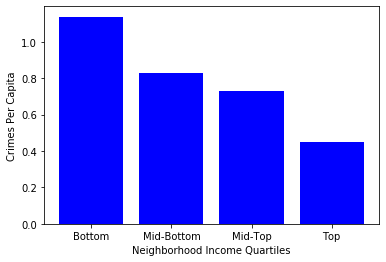

In [13]:
#Split neighborhoods into different quartiles based on median income
quartiles = pop_df["Median Income (K)"].quantile([.25, .5, .75])
#upper quartile
up_quart = quartiles[.75]
#median
mid_quart = quartiles[.5]
#lower quartile
low_quart = quartiles[.25]
#inner quartile range
iqr = up_quart - low_quart
#top of whisker
box_max = up_quart + (1.5*iqr)
#bottom of whisker
box_min = low_quart - (1.5*iqr)
#all neighborhoods whose median income falls between bottom whisker and bottom of the box
bottom = pop_df.loc[(pop_df["Median Income (K)"] < low_quart) & (pop_df["Median Income (K)"] > box_min)]
#all neighborhhods whose median income falls between bottom of the box and the median
mid_bottom = pop_df.loc[(pop_df["Median Income (K)"] < mid_quart) & (pop_df["Median Income (K)"] > low_quart)]
#all neighborhoods whose median income falls between median and top of the box
mid_top = pop_df.loc[(pop_df["Median Income (K)"] < up_quart) & (pop_df["Median Income (K)"] > mid_quart)]
#all neighborhoods whose median income falls betweentop of the box and top whisker
top = pop_df.loc[(final_df["Median Income (K)"] < box_max) & (pop_df["Median Income (K)"] > up_quart)]
#count up the crimes in each income range
bot_count = bottom["Crime Per Capita"].mean()
midbot_count = mid_bottom["Crime Per Capita"].mean()
midtop_count = mid_top["Crime Per Capita"].mean()
top_count = top["Crime Per Capita"].mean()
#lists for x and y values
crime_counts = [bot_count, midbot_count, midtop_count, top_count]
crime_quarts = ["Bottom", "Mid-Bottom", "Mid-Top", "Top"]
#bar chart showing number of crime vs neighborhood income quartiles
plt.bar(crime_quarts, crime_counts, color = "b", align = "center")
plt.xlabel("Neighborhood Income Quartiles")
plt.ylabel("Crimes Per Capita")

Text(100, 1.5, 'y = -0.01x + 1.16')

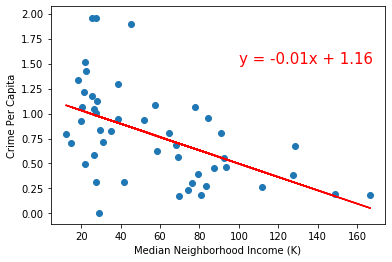

In [14]:
#Scatter plot ith crime per capita and median income by neighborhood
scat_x = pop_df["Median Income (K)"]
scat_y = pop_df["Crime Per Capita"]
plt.scatter(scat_x, scat_y)
plt.xlabel("Median Neighborhood Income (K)")
plt.ylabel("Crime Per Capita")
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(scat_x, scat_y)
regress_values = scat_x * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(scat_x,regress_values,"r-")
plt.annotate(line_eq,(100, 1.5),fontsize=15,color="red")

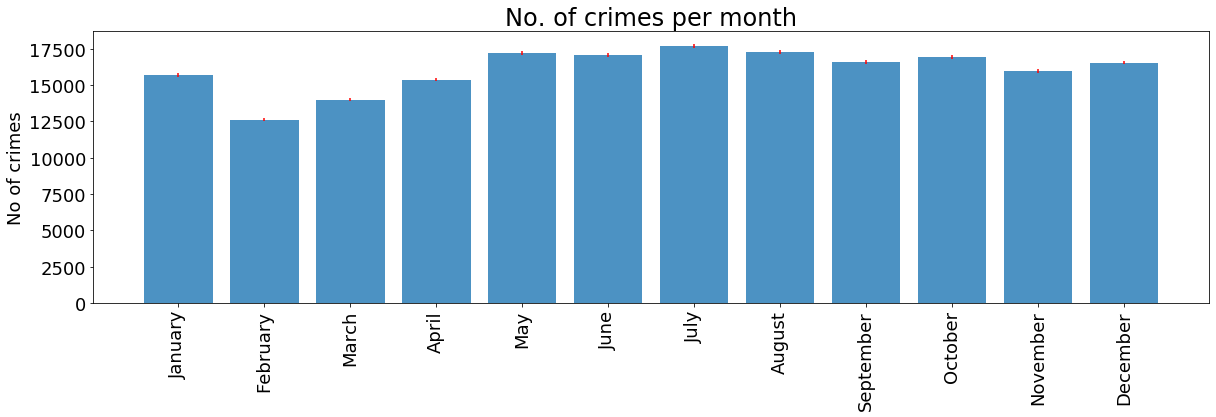

The standard deviation of the distribution =  1487.7109399708972
The mean number of crimes per month = 16079.25
critical value = 19.67513757268249
Power_divergenceResult(statistic=1514.1329508528072, pvalue=0.0)


Month
1     15691
2     12621
3     13997
4     15379
5     17191
6     17078
7     17687
8     17255
9     16572
10    16933
11    15989
12    16558
Name: UCR #, dtype: int64

<Figure size 432x288 with 0 Axes>

In [15]:

dates = final_df["Occur Date"]
#create a temporay df to keep the date info
#make sure to import datetime
df = pd.DataFrame({'Occur Date': pd.to_datetime(dates)})
#we need year, month and dayofweek
date_terms = ['year', 'month', 'day','dayofweek']
#generate year, month, day, dayofweek
date_gen = (getattr(df['Occur Date'].dt, i).rename(i) for i in date_terms)
#add the new columns
df = df.join(pd.concat(date_gen, axis=1))

#need to add the info to the crime data
Month = df["month"]
dayofweek = df["dayofweek"]
year = df["year"]

final1_df = final_df.assign(Month = Month,Year = year,Dayofweek = dayofweek)
#final1_df["Dayofweek"].unique()
#Week of the day: 0-Monday, 1-Tuesday.....6-Sunday
months_df = final1_df.groupby(final1_df["Month"])
crimes_per_month = months_df["UCR #"].count()
x_values = np.arange(len(final1_df["Month"].unique()))
tick_locations = [value for value in x_values]
months =["January", "February", "March", "April", "May", "June", "July","August","September",
        "October","November","December"]
plt.figure(figsize=(20,5))
plt.xticks(tick_locations, months, rotation="vertical",fontsize=18)
error = crimes_per_month**(1/2)
plt.bar(x_values, crimes_per_month,yerr=error,align='center', alpha=0.8, ecolor='red')
plt.title("No. of crimes per month",fontsize=24)
plt.ylabel("No of crimes",fontsize=18)
plt.yticks(fontsize=18)

plt.show()
plt.tight_layout()
print("The standard deviation of the distribution = ", crimes_per_month.std())
mean_month = crimes_per_month.mean()
print ("The mean number of crimes per month =",mean_month )

#check if the changes are significant
crimes_month_df = pd.DataFrame([crimes_per_month]).T
crimes_month_df[1]=mean_month
crimes_month_df.columns=["observed crimes", "average crimes"]
#degree of freedom is 11, confidence level=95%
critical_value = stats.chi2.ppf(q = 0.95, df = 11)
print("critical value =",critical_value)
#running the chisq test
print(stats.chisquare(crimes_month_df['observed crimes'], crimes_month_df['average crimes']))
crimes_per_month

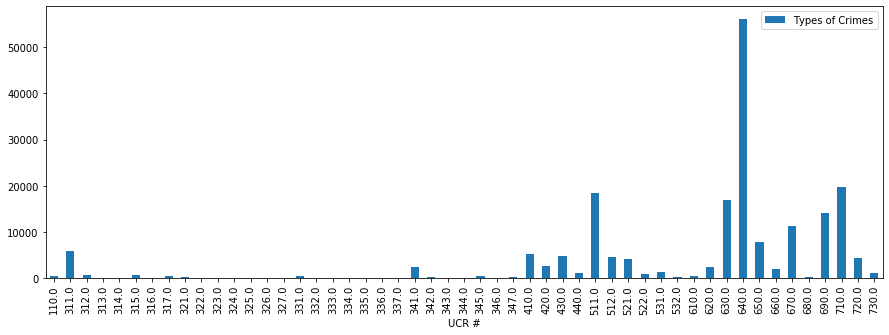

In [16]:
types_of_crimes = final1_df.groupby(final1_df["UCR #"])
x_values= types_of_crimes["UCR #"].unique()
types= types_of_crimes["UCR #"].count()
crime_type_df = pd.DataFrame({"Types of Crimes":types})
#plt.figure(figsize=(20,5))
#plt.bar(x_values, types)

#plt.show()
#plt.tight_layout()
#types_of_crimes["UCR #"].unique())
crime_type_df.plot(kind="bar", figsize=(15,5))

<BarContainer object of 10 artists>

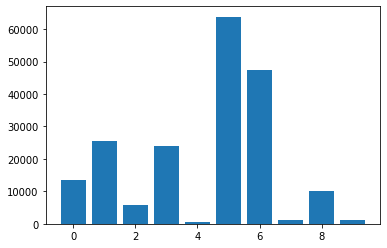

In [18]:
littypes_per_month = lit_types["UCR Literal"].count()
lit_values = np.arange(len(final1_df["UCR Literal"].unique()))
plt.bar(lit_values, littypes_per_month)

In [17]:
#types
lit_types =final1_df.groupby(final1_df["UCR Literal"])
lit_type = lit_types["UCR Literal"].count()
lit_type

UCR Literal
AGG ASSAULT             13609
AUTO THEFT              25430
BURGLARY-NONRES          5750
BURGLARY-RESIDENCE      23982
HOMICIDE                  517
LARCENY-FROM VEHICLE    63828
LARCENY-NON VEHICLE     47421
ROBBERY-COMMERCIAL       1307
ROBBERY-PEDESTRIAN       9973
ROBBERY-RESIDENCE        1134
Name: UCR Literal, dtype: int64

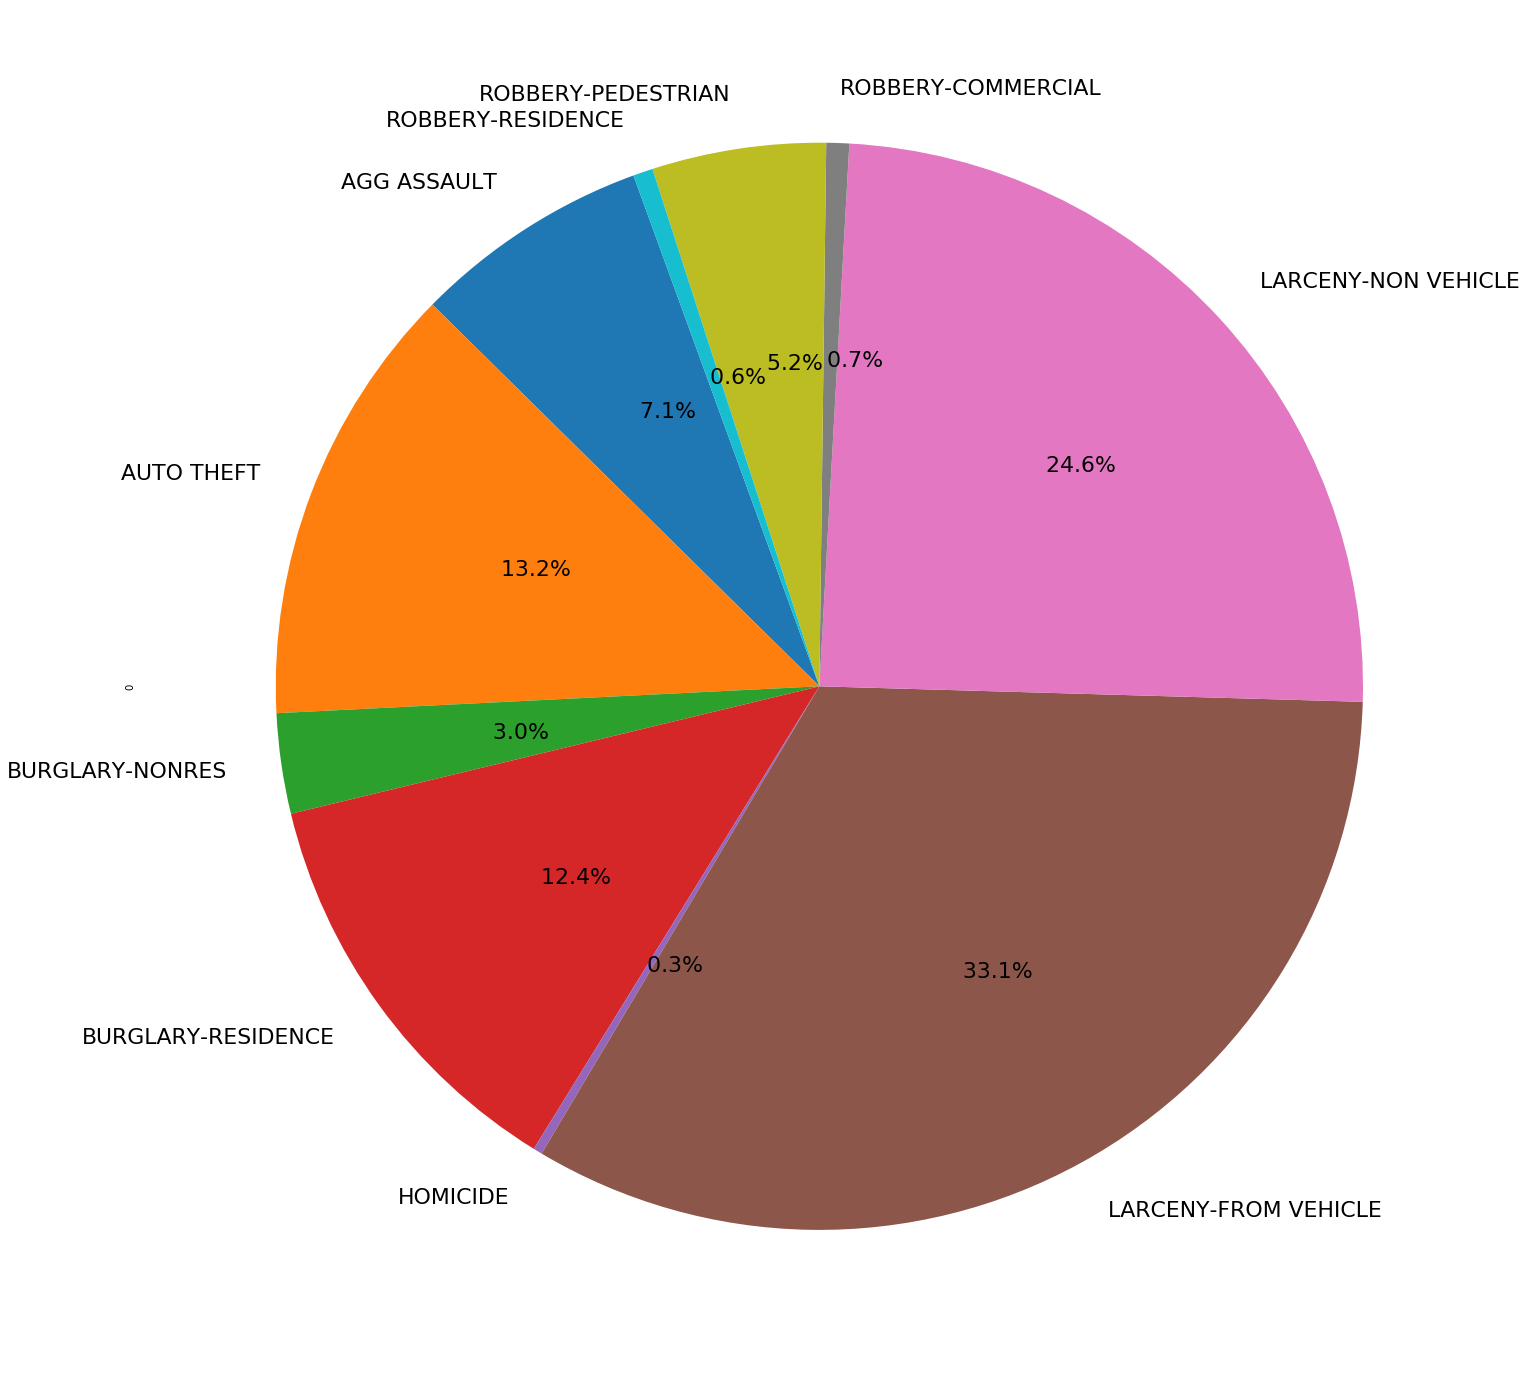

In [80]:


summary = pd.DataFrame(final_df.groupby("UCR Literal").size())

# Use DataFrame.plot() in order to create a bar chart of the da
summary.plot(kind="pie", labels=summary.index.values, 
        autopct="%10.1f%%",subplots=True,figsize=(25,25),fontsize=22, startangle=110,legend=False)
#colors = ['lightskyblue', 'red', 'blue', 'green', 'gold']
#plt.pie(df_score_2['Stat'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')

plt.show()

In [19]:
final1_df["UCR Literal"].value_counts()
final1_df.loc[final1_df["UCR #"] == 730]

,Report Number,Occur Date,Occur Time,Location,UCR Literal,UCR #,Neighborhood,Latitude,Longitude,Median Income (K),Population (K),Month,Year,Dayofweek
1681,113212349.0,2011-11-17,1700,2990 HOGAN RD SW,AUTO THEFT,730.0,Greenbriar,33.67781,-84.48674,21.8,3.63,11,2011,3
1754,113620464.0,2011-12-28,455,20 PINE CANYON DR SW,AUTO THEFT,730.0,Greenbriar,33.67567,-84.48684,21.8,3.63,12,2011,2
2061,122090601.0,2012-07-27,555,2975 CONTINENTAL COLONY PKWY SW,AUTO THEFT,730.0,Greenbriar,33.68087,-84.49392,21.8,3.63,7,2012,4
3103,141542929.0,2014-05-23,2100,3200 STONE RD SW,AUTO THEFT,730.0,Greenbriar,33.66970,-84.49403,21.8,3.63,5,2014,4
3808,153383349.0,2015-12-03,1900,3171 TOPAZ LN SW,AUTO THEFT,730.0,Greenbriar,33.67532,-84.49199,21.8,3.63,12,2015,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307844,192480728.0,2019-09-05,920,862 MARTIN L KING JR DR SW,AUTO THEFT,730.0,Atlanta University Center,33.75462,-84.41596,27.3,5.91,9,2019,3
312673,112700362.0,2011-09-26,1800,187 FAIRBURN RD SW,AUTO THEFT,730.0,Fairburn Mays,33.75060,-84.50773,21.7,3.42,9,2011,0
313193,143021941.0,2014-10-29,700,3610-7 GINNIS RD SW,AUTO THEFT,730.0,Fairburn Mays,33.73158,-84.51109,21.7,3.42,10,2014,2
313241,150570747.0,2015-02-25,2200,400 FAIRBURN RD SW,AUTO THEFT,730.0,Fairburn Mays,33.74366,-84.50936,21.7,3.42,2,2015,2


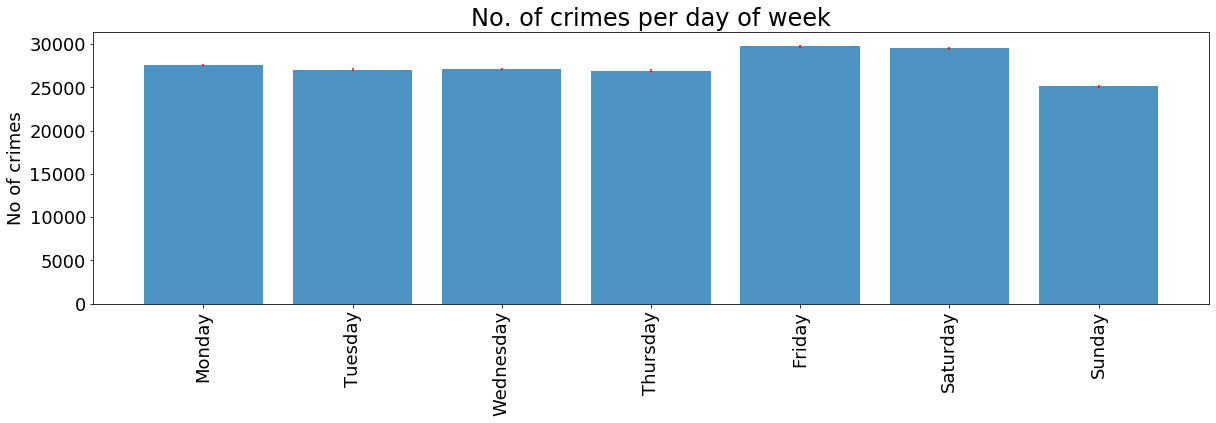

The standard deviation of the distribution =  1601.2857185340013
The mean number of crimes per month = 27564.428571428572
critical value = 12.591587243743977
Power_divergenceResult(statistic=558.1358479613995, pvalue=2.4879567385153532e-117)


Dayofweek
0    27569
1    27019
2    27100
3    26926
4    29743
5    29485
6    25109
Name: UCR #, dtype: int64

<Figure size 432x288 with 0 Axes>

In [20]:
crimes_dayofweek =final1_df.groupby(final1_df["Dayofweek"])
dayofweek= crimes_dayofweek["UCR #"].count()
x_dayofweek = np.arange(len(final1_df["Dayofweek"].unique()))

tick_locations = [value for value in x_dayofweek]
daysofweek =["Monday", "Tuesday", "Wednesday", "Thursday","Friday", "Saturday", "Sunday"]
plt.figure(figsize=(20,5))
error_week = dayofweek**(1/2)
plt.xticks(tick_locations, daysofweek, rotation="vertical",fontsize=18)
#plt.bar(x_values, crimes_per_month)
plt.bar(x_dayofweek, dayofweek,yerr=error_week,align='center', alpha=0.8, ecolor='red')
plt.title("No. of crimes per day of week",fontsize=24)
plt.ylabel("No of crimes",fontsize=18)
plt.yticks(fontsize=18)
plt.show()
plt.tight_layout()
print("The standard deviation of the distribution = ", dayofweek.std())
mean_week = dayofweek.mean()
print ("The mean number of crimes per month =",mean_week)

#chi square test
crimes_week_df = pd.DataFrame([dayofweek]).T
crimes_week_df[1]=mean_week
crimes_week_df.columns=["observed crimes", "average crimes"]
#degree of freedom is 11, confidence level=95%
critical_value1 = stats.chi2.ppf(q = 0.95, df = 6)
print("critical value =",critical_value1)
#running the chisq test
print(stats.chisquare(crimes_week_df['observed crimes'], crimes_week_df['average crimes']))
dayofweek

In [21]:

gmaps.configure(g_key)
final_df.head()

,Report Number,Occur Date,Occur Time,Location,UCR Literal,UCR #,Neighborhood,Latitude,Longitude,Median Income (K),Population (K)
0,90010930.0,2009-01-01,1145,2841 GREENBRIAR PKWY,LARCENY-NON VEHICLE,630.0,Greenbriar,33.68845,-84.49328,21.8,3.63
1,90011289.0,2009-01-01,1600,2841 GREENBRIAR PKWY SW,LARCENY-NON VEHICLE,630.0,Greenbriar,33.68677,-84.49773,21.8,3.63
2,90010721.0,2009-01-01,815,3030 HEADLAND DR SW,LARCENY-NON VEHICLE,630.0,Greenbriar,33.68841,-84.48742,21.8,3.63
3,90011602.0,2009-01-01,2000,2841 GREENBRIAR PKWY SW,LARCENY-FROM VEHICLE,640.0,Greenbriar,33.68677,-84.49773,21.8,3.63
4,90010939.0,2009-01-01,200,3000 STONE HOGAN CONN SW,AUTO THEFT,710.0,Greenbriar,33.67424,-84.49697,21.8,3.63


In [22]:
neighborhood_detail_df = final_df.groupby("Neighborhood").mean()
neighborhood_detail_df.reset_index(inplace = True)
neighborhood_detail_df.head()

,Neighborhood,Report Number,UCR #,Latitude,Longitude,Median Income (K),Population (K)
0,Atlanta University Center,1.345378e+08,578.025627,33.751600,-84.412137,27.3,5.91
1,Bolton,1.419848e+08,603.387500,33.816475,-84.450677,76.4,3.92
2,Brookwood Hills,1.396377e+08,619.219697,33.805375,-84.392540,148.6,2.70
3,Campbellton Road,1.309839e+08,562.382778,33.702915,-84.460063,14.6,5.08
4,Candler Park,1.397479e+08,621.934713,33.765461,-84.342958,92.4,3.40


In [23]:
neighborhood_locations = neighborhood_detail_df[["Latitude", "Longitude"]]

#hotel_info = [info_box_template.format(**row) for index, row in ideal_df.iterrows()]

info_box_neighborhood = """
<dl>
<dt>Name</dt><dd>{Neighborhood}</dd>
<dt>Median Income</dt><dd>{Median Income (K)}</dd>
<dt>Population</dt><dd>{Population (K)}</dd>
</dl>
"""
neighborhood_info = [info_box_neighborhood.format(**row) for index, row in neighborhood_detail_df.iterrows()]


In [81]:
crime_location = final_df[["Latitude", "Longitude"]]

# locations

#neighborhood = final_df["Neighborhood"].astype(float)



fig = gmaps.figure()

heatmap_layer = gmaps.heatmap_layer(crime_location,
                                   dissipating=False, max_intensity=10,
                                   point_radius=.001)
#markers = gmaps.marker_layer(neighborhood_locations, info_box_content = neighborhood_info)
#fig.add_layer(markers)
fig.add_layer(heatmap_layer)


fig


Figure(layout=FigureLayout(height='420px'))

In [25]:
lit_type

UCR Literal
AGG ASSAULT             13609
AUTO THEFT              25430
BURGLARY-NONRES          5750
BURGLARY-RESIDENCE      23982
HOMICIDE                  517
LARCENY-FROM VEHICLE    63828
LARCENY-NON VEHICLE     47421
ROBBERY-COMMERCIAL       1307
ROBBERY-PEDESTRIAN       9973
ROBBERY-RESIDENCE        1134
Name: UCR Literal, dtype: int64

In [26]:
locations = crimes_df[["Latitude", "Longitude"]]

# locations

rprt_num = crimes_df["Report Number"].astype(float)



fig = gmaps.figure()

crime_layer = gmaps.heatmap_layer(locations,
                                   dissipating=False, max_intensity=7,
                                   point_radius=0.001)

markers = gmaps.marker_layer(neighborhood_locations, info_box_content = neighborhood_info)
fig.add_layer(markers)
fig.add_layer(crime_layer)

fig


Figure(layout=FigureLayout(height='420px'))

In [27]:
homicide_df = final_df.loc[final_df["UCR Literal"] == 'HOMICIDE']
rob_res_df = final_df.loc[final_df["UCR Literal"] == 'ROBBERY-RESIDENCE']
homicide_locations = homicide_df[["Latitude", "Longitude"]]
rob_res_locations = rob_res_df[["Latitude", "Longitude"]]
auto_df = final_df.loc[final_df["UCR Literal"] == 'AUTO THEFT']
auto_locations = auto_df[["Latitude", "Longitude"]]
assault_df = final_df.loc[final_df["UCR Literal"] == 'AGG ASSAULT']
assault_locations = assault_df[["Latitude", "Longitude"]]

In [28]:
fig = gmaps.figure()

rob_res_heatmap_layer = gmaps.heatmap_layer(rob_res_locations,
                                   dissipating=False, max_intensity=2,
                                   point_radius=.001)

markers = gmaps.marker_layer(neighborhood_locations, info_box_content = neighborhood_info)
fig.add_layer(markers)
fig.add_layer(rob_res_heatmap_layer)


fig

Figure(layout=FigureLayout(height='420px'))

In [29]:
fig = gmaps.figure()

auto_heatmap_layer = gmaps.heatmap_layer(auto_locations,
                                   dissipating=False, max_intensity=2,
                                   point_radius=.001)

markers = gmaps.marker_layer(neighborhood_locations, info_box_content = neighborhood_info)
fig.add_layer(markers)
fig.add_layer(auto_heatmap_layer)


fig

Figure(layout=FigureLayout(height='420px'))

In [30]:
fig = gmaps.figure()

assault_heatmap_layer = gmaps.heatmap_layer(assault_locations,
                                   dissipating=False, max_intensity=5,
                                   point_radius=.001)

markers = gmaps.marker_layer(neighborhood_locations, info_box_content = neighborhood_info)
fig.add_layer(markers)
fig.add_layer(assault_heatmap_layer)


fig

Figure(layout=FigureLayout(height='420px'))

In [31]:
fig = gmaps.figure()

homicide_heatmap_layer = gmaps.heatmap_layer(homicide_locations,
                                   dissipating=False, max_intensity=2,
                                   point_radius=.001)

markers = gmaps.marker_layer(neighborhood_locations, info_box_content = neighborhood_info)
fig.add_layer(markers)
fig.add_layer(homicide_heatmap_layer)


fig

Figure(layout=FigureLayout(height='420px'))